In [1]:
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import rdDepictor, rdMolDescriptors

from

import time
rdDepictor.SetPreferCoordGen(True)
import rdkit
%pylab inline
print(rdkit.__version__)

Populating the interactive namespace from numpy and matplotlib
2020.09.1


In [2]:
import pandas as pd

In [4]:
data_dir = '/rds-d7/project/rds-ZNFRY9wKoeE/EnamineREAL/data/'
target = 'mpro'

df = pd.read_csv(data_dir+'../topN/topN_new_filtered_' + target+'.csv')


In [5]:
furan = Chem.MolFromSmarts('[o]1[c][c][c][c]1')
thiophene = Chem.MolFromSmarts('[s]1[c][c][c][c]1')
thiol = Chem.MolFromSmarts('[S][#1]')
phenol = Chem.MolFromSmarts('[c]1[c][c][c][c][c]1[O][#1]')
nitro = Chem.MolFromSmarts('[c][$([NX3](=O)=O),$([NX3+](=O)[O-])]')

boronic_acid = Chem.MolFromSmarts('B')
sulphonic_acid = Chem.MolFromSmarts('[S][O]')

In [6]:
df["alerts"] = [(Chem.MolFromSmiles(ind).HasSubstructMatch(furan) or 
                 Chem.MolFromSmiles(ind).HasSubstructMatch(thiophene) or 
                 Chem.AddHs(Chem.MolFromSmiles(ind)).HasSubstructMatch(thiol) or 
                 Chem.AddHs(Chem.MolFromSmiles(ind)).HasSubstructMatch(phenol) or 
                 Chem.AddHs(Chem.MolFromSmiles(ind)).HasSubstructMatch(nitro)) 
                for ind in df["smiles"]]

In [7]:
df = df[~df["alerts"]].reset_index()

In [8]:
from rdkit.Chem import rdMolDescriptors
ms = [Chem.MolFromSmiles(x) for x in df["smiles"]]
fps = [rdMolDescriptors.GetMorganFingerprintAsBitVect(m, 2, 2048) for m in ms]

In [9]:
len(ms)

25589

In [10]:
from rdkit.SimDivFilters import rdSimDivPickers
lp = rdSimDivPickers.LeaderPicker()

In [11]:
thresh = 0.75 # <- minimum distance between cluster centroids
picks = lp.LazyBitVectorPick(fps,len(fps),thresh)
print(len(picks))

210


In [12]:
from rdkit.DataManip.Metric import GetTanimotoDistMat
from rdkit.SimDivFilters.rdSimDivPickers import HierarchicalClusterPicker, ClusterMethod

ward = HierarchicalClusterPicker(ClusterMethod.WARD)
ids = ward.Pick(GetTanimotoDistMat(fps), len(ms), 60)

In [25]:
import mols2grid

mols2grid.display([ms[x] for x in ids], template="table",
                  n_rows=15, n_cols=4, subset=["img"], tooltip=['SMILES'], maxMols=60, size=(300, 150))


In [26]:
smi = [Chem.MolToSmiles(ms[x]) for x in ids]

In [ ]:
sim_mat = np.empty((len(fps), len(fps)))
for i in range(len(fps)):

    sim_mat[i] = np.array(DataStructs.BulkTanimotoSimilarity(fps[i], fps))

plt.matshow(sim_mat)

In [28]:
data_dir = '/rds-d7/project/rds-ZNFRY9wKoeE/EnamineREAL/data/'

pd.DataFrame(smi, columns=['smiles']).to_csv(data_dir+'../topN/'+target+'_picks.csv', index=False)


In [42]:
from collections import defaultdict
import numpy as np

def assignPointsToClusters(picks,fps):
    clusters = defaultdict(list)
    for i,idx in enumerate(picks):
        clusters[i].append(idx)
    sims = np.zeros((len(picks),len(fps)))
    for i in range(len(picks)):
        pick = picks[i]
        sims[i,:] = DataStructs.BulkTanimotoSimilarity(fps[pick],fps)
        sims[i,i] = 0
    best = np.argmax(sims,axis=0)
    for i,idx in enumerate(best):
        if i not in picks:
            clusters[idx].append(i)
    return clusters

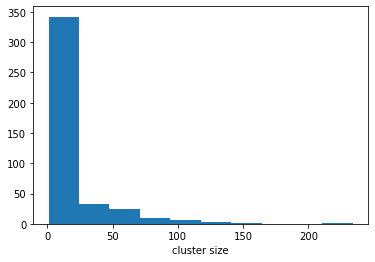

In [43]:
clusters = assignPointsToClusters(picks,fps)
hist([len(clusters[x]) for x in clusters]);
xlabel('cluster size');

In [44]:
clusts12 = [x for x in clusters if len(clusters[x])==16]
len(clusts12)

7

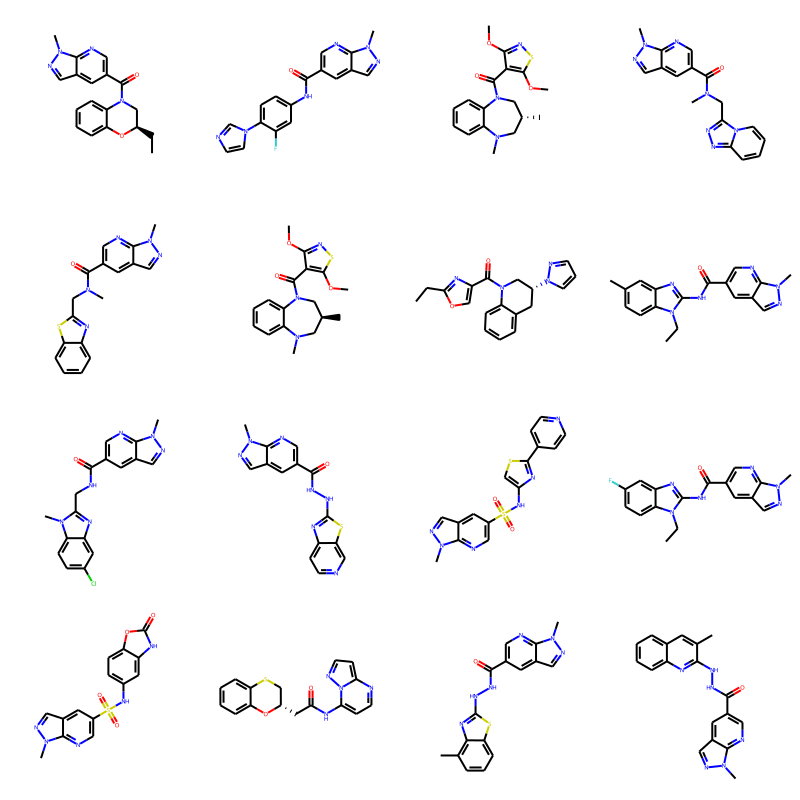

In [48]:
Draw.MolsToGridImage([ms[x] for x in clusters[clusts12[3]]],molsPerRow=4)
